# Bayesian Inference with Stan

### Bayesian Workflow

In general the Bayesian workflow consists of steps:

- Consider the social process that generates your data. The goal of your statistical model should be to model the data generating process, so think hard about this. Exploratory analysis goes a long way towards helping you to understand this process.
- Program your statistical model and sample from it.
- Evaluate your model’s reliability. Check for Markov chain convergence to make sure that your model has produced reliable estimates.
- Evaluate your model’s performance. How well does your model approximate the data generating process? This involves using posterior predictive checks.
- Summarize your model’s results in tabular and graphical form.

### Imports

In [14]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

from matplotlib import style 
style.use('../../PlottingStyle.mplstyle')

%config InlineBackend.figure_formats = ['svg']

### Stan Syntax

Stan requires the coding of your model in different blocks and in a specific order. In order, these blocks are data, transformed data, parameters, transformed parameters, model, and generated quantities. Let’s suppose that we wanted to estimate the following equation with Stan:

$$
\begin{aligned}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta x \\
\alpha &\sim \text{Normal}(0, 10)\\
\beta &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$

A complete Stan program for this model looks like the following:

In [2]:
linear_reg_1 = '''
data {              // This is the data block
    int N;          // Specify Sample Size
    array[N] real y;      // A variable named y with length n
    array[N] real x;      // A variable named x with length n
}

transformed data {
  // this is where you could specify variable transformations
}

parameters {        // Block for parameters to be estimated
  real a;           // A parameter named a
  real b;           // A parameter named b
  real sigma;       // A parameter named sigma
}

transformed parameters {
  // Here you could specify transformations of your parameters
}

model {
  vector[N] mu;     // create the linear predictor mu

  // Write the linear model
  for (i in 1:N) {
    mu[i] = a + b * x[i];
  }

  // Write out priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ uniform(0, 100);

  // Write out the likelihood function
  for (i in 1:N) {
  y[i] ~ normal(mu[i], sigma);
  }
}

generated quantities {
  // Here you can calculate things like log-likelihood, replication data, etc.
}
'''

In [3]:
stan_file = './stan_models/linear_reg_1.stan'
with open(stan_file, 'w') as f:
    print(linear_reg_1, file=f)

stan_model = CmdStanModel(stan_file=stan_file, force_compile=True, cpp_options={'STAN_THREADS':'true'})

14:59:18 - cmdstanpy - INFO - compiling stan file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/linear_reg_1.stan to exe file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/linear_reg_1
14:59:27 - cmdstanpy - INFO - compiled model executable: /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/linear_reg_1


After programming the model, you run the code which will tell Python to compile it into a model. From there we are ready to sample from the model. Note that Stan is case sensitive and each line must terminate with a semi-colon “;”.

### Example: Exploratory Analysis

In [4]:
mpg = pd.read_csv('../../data/mpg.csv', sep=',', header=0)
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


This data set contains data on the make and model over different cars along with their engine type, transmission type, and mpg. Let’s do some visualizations to get a better understanding of our data.

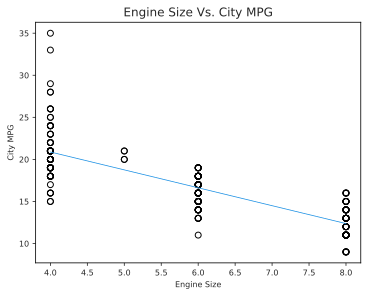

In [15]:
m, b = np.polyfit(mpg.cyl, mpg.cty, 1)
plt.plot(mpg.cyl, mpg.cty, 'o', fillstyle='none')
plt.plot(mpg.cyl, m * mpg.cyl + b)
plt.title('Engine Size Vs. City MPG')
plt.xlabel('Engine Size')
plt.ylabel('City MPG');

As expected, there is a negative relationship between engine size and city MPG. Let’s build a simple linear model to see if engine type affects mpg. In mathematical notation, this model would look like:

$$
\begin{aligned}
mpg_i &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= \alpha + \beta \times \text{Engine}_i \\
\alpha &\sim \text{Normal}(0, 100)\\
\beta &\sim \text{Normal}(0, 100)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$


#### Prior Simulation

Notice that I am specifying pretty uninformative priors. To see just how uninformative, let’s do some simulations. Centering continuous variables can also help to interpret priors.

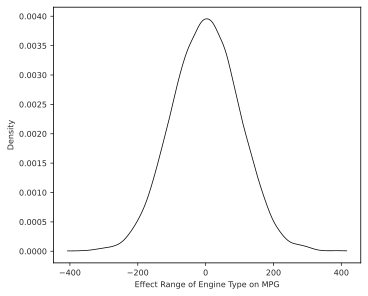

In [18]:
# draw from a normal distribution
sim_data = np.random.normal(0, 100, 10_000)

az.plot_kde(sim_data)
plt.xlabel('Effect Range of Engine Type on MPG')
plt.ylabel('Density');

So, we are telling the model that the average effect of engine type on MPG will be zero, but can range between a decrease of 200 and an increase of 200 MPG with reasonably high probability. Thus, this is a pretty flat prior. Cars with bigger engines will probably get lower MPG, but they probably don’t get 200 MPG lower! This is a good time to point out that uninformative priors are rarely ever a good idea since we almost always know something about the effects we are interested in before we estimate them.

Finally, let’s examine the prior for $\sigma$.

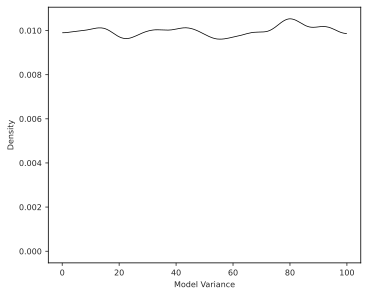

In [19]:
sim_data = np.random.uniform(0, 100, 10_000)

az.plot_kde(sim_data)
plt.xlabel('Model Variance')
plt.ylabel('Density');

#### Model Programming

Now that we know what we are telling the model a priori, let’s program the model.

##### Vectorized Syntax

In [25]:
mpg_model_1 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length n
    vector[N] engine;            // Variable called weight as a vector of length n
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  alpha ~ normal(0, 100);
  beta ~ normal(0, 100);
  sigma ~ uniform(0, 100);

  // Likelihood function
  mpg ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

In [26]:
stan_file = './stan_models/mpg_model_1.stan'
with open(stan_file, 'w') as f:
    print(mpg_model_1, file=f)

stan_model = CmdStanModel(stan_file=stan_file, force_compile=True, cpp_options={'STAN_THREADS':'true'})

15:24:59 - cmdstanpy - INFO - compiling stan file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1.stan to exe file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1
15:25:08 - cmdstanpy - INFO - compiled model executable: /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1


##### Target+ Syntax

Stan allows users to directly specify the log-posterior using target+ syntax. Using this syntax, `y ~ normal(mu, sigma)`; becomes `target += normal_lpdf(y | mu, sigma)`. This directly updates the target log density.

In [28]:
mpg_model_1a = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length n
    vector[N] engine;            // Variable called weight as a vector of length n
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  target += normal_lpdf(alpha | 0, 100);
  target += normal_lpdf(beta | 0, 100);
  target += uniform_lpdf(sigma | 0, 100);

  // Likelihood function
  target += normal_lpdf(mpg | mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

In [29]:
stan_file = './stan_models/mpg_model_1a.stan'
with open(stan_file, 'w') as f:
    print(mpg_model_1a, file=f)

stan_model = CmdStanModel(stan_file=stan_file, force_compile=True, cpp_options={'STAN_THREADS':'true'})

15:28:41 - cmdstanpy - INFO - compiling stan file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1a.stan to exe file /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1a
15:28:50 - cmdstanpy - INFO - compiled model executable: /Users/rehabnaeem/Documents/Coding-Projects/bayesian-analysis/references/Stan-Modelling/stan_models/mpg_model_1a


Now, let’s get into running some linear models.

### Linear Models in Stan

We’ll use the Motor Trend Car Road Tests `mtcars` data as our practice data set.

Let’s walk though what our variables are:

- `mpg`: Miles pre gallon
- `cyl`: Number of cylinders
- `disp` Displacement (cu. in.)
- `hp`: Gross horsepower
- `drat`: Rear axle ratio
- `wt`: Weight (1000 lbs)
- `qsec`: 1/4 mile time
- `vs`: Engine (0 = V-shaped, 1 = straight)
- `am`: Transmission (0 = automatic, 1 = manual)
- `gear`: Number of forward gears
- `carb`: Number of carburetors

In [30]:
mtcars = pd.read_csv('../../data/mtcars.csv', sep=',', header=0)
mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


For our research question, we will be investigating how different characteristics of a car affect it’s MPG. To start with, we will test how vehicle weight affects MPG. Let’s do some preliminary analysis of this question with visualizations.

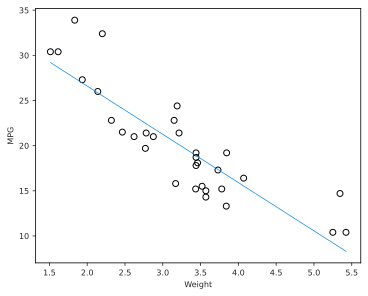

In [40]:
m, b = np.polyfit(mtcars.wt, mtcars.mpg, 1)
plt.plot(mtcars.wt, mtcars.mpg, 'o', fillstyle='none')
plt.plot(mtcars.wt, m * mtcars.wt + b)
plt.xlabel('Weight')
plt.ylabel('MPG');

As expected, there seems to be a negative relationship between these variables. Let’s add in a fitted line: